In [1]:
import os
import sys
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

import matplotlib.pyplot as plt
import seaborn as sns

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from data.load_data import download_creditcard_data, load_creditcard_df

# Project step 4: XGBoost on credit card fraud detection

In this notebook we use XGBoost, a gradient boosting algorithm that builds trees sequentially. Each new tree tries to fix the mistakes of the previous ones. Its known for being fast and accurate on tabular data like ours.

In [3]:
download_creditcard_data()
df = load_creditcard_df()

df = df.drop_duplicates().reset_index(drop=True)

In [4]:
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {len(X_train)}, Fraud cases: {y_train.sum()}")
print(f"Test size: {len(X_test)}, Fraud cases: {y_test.sum()}")

Train size: 226980, Fraud cases: 378
Test size: 56746, Fraud cases: 95


In [5]:
numeric_to_scale = ["Time", "Amount"]
other_features = [col for col in X.columns if col not in numeric_to_scale]

preprocessor = ColumnTransformer(
    transformers=[
        ("scale_time_amount", StandardScaler(), numeric_to_scale),
        ("pass_others", "passthrough", other_features),
    ]
)

## 1. Baseline XGBoost

XGBoost handles imbalanced data with the scale_pos_weight parameter. We set it to the ratio of negative to positive samples.

In [6]:
# calculate class imbalance ratio
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight: {scale_pos:.2f}")

baseline_xgb = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", XGBClassifier(
            n_estimators=100,
            scale_pos_weight=scale_pos,
            random_state=42,
            n_jobs=-1,
            eval_metric="logloss",
        )),
    ]
)

baseline_xgb.fit(X_train, y_train)

y_pred_baseline = baseline_xgb.predict(X_test)
y_proba_baseline = baseline_xgb.predict_proba(X_test)[:, 1]

print("\nBaseline XGBoost results:")
print(classification_report(y_test, y_pred_baseline, digits=4))

scale_pos_weight: 599.48

Baseline XGBoost results:
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56651
           1     0.9605    0.7684    0.8538        95

    accuracy                         0.9996     56746
   macro avg     0.9801    0.8842    0.9268     56746
weighted avg     0.9995    0.9996    0.9995     56746



## 2. Hyperparameter tuning

XGBoost has many parameters. The most important ones are:
- n_estimators: number of trees
- max_depth: depth of each tree
- learning_rate: how much each tree contributes
- subsample: fraction of samples used per tree
- colsample_bytree: fraction of features used per tree

We use RandomizedSearchCV to explore different combinations.

In [7]:
from scipy.stats import randint, uniform

xgb_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", XGBClassifier(
            scale_pos_weight=scale_pos,
            random_state=42,
            n_jobs=-1,
            eval_metric="logloss",
        )),
    ]
)

param_distributions = {
    "model__n_estimators": randint(50, 200),
    "model__max_depth": randint(3, 10),
    "model__learning_rate": uniform(0.01, 0.29),
    "model__subsample": uniform(0.6, 0.4),
    "model__colsample_bytree": uniform(0.6, 0.4),
}

In [8]:
random_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

random_search.fit(X_train, y_train)

print(f"\nBest parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV F1 score: {random_search.best_score_:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters:
  model__colsample_bytree: 0.9757995766256756
  model__learning_rate: 0.26949993162401814
  model__max_depth: 8
  model__n_estimators: 144
  model__subsample: 0.9687496940092467

Best CV F1 score: 0.8637


In [9]:
best_xgb = random_search.best_estimator_

y_pred_tuned = best_xgb.predict(X_test)
y_proba_tuned = best_xgb.predict_proba(X_test)[:, 1]

print("Tuned XGBoost results:")
print(classification_report(y_test, y_pred_tuned, digits=4))

Tuned XGBoost results:
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56651
           1     0.9610    0.7789    0.8605        95

    accuracy                         0.9996     56746
   macro avg     0.9803    0.8894    0.9301     56746
weighted avg     0.9996    0.9996    0.9996     56746



## 3. Comparison: baseline vs tuned

In [10]:
def compute_metrics(y_true, y_pred, y_proba, name):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba),
    }

results = []
results.append(compute_metrics(y_test, y_pred_baseline, y_proba_baseline, "XGB Baseline"))
results.append(compute_metrics(y_test, y_pred_tuned, y_proba_tuned, "XGB Tuned"))

results_df = pd.DataFrame(results)
results_df

,model,accuracy,precision,recall,f1,roc_auc
0,XGB Baseline,0.999559,0.960526,0.768421,0.853801,0.979006
1,XGB Tuned,0.999577,0.961039,0.778947,0.860465,0.978030


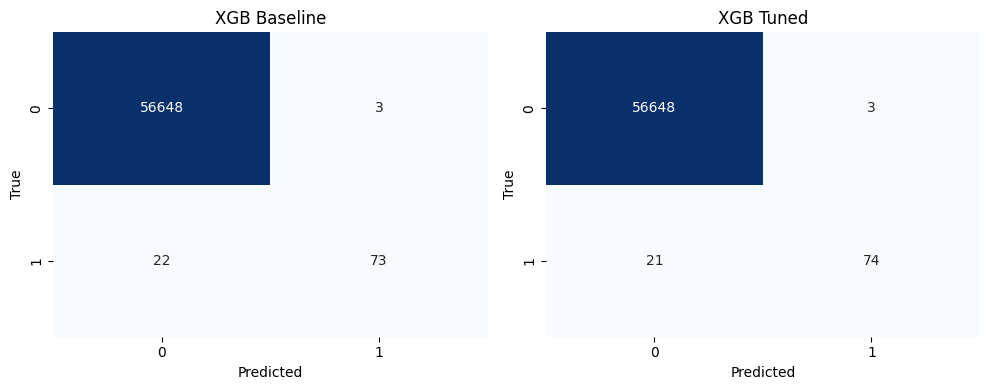

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

models_preds = {
    "XGB Baseline": y_pred_baseline,
    "XGB Tuned": y_pred_tuned,
}

for ax, (name, y_pred) in zip(axes, models_preds.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()

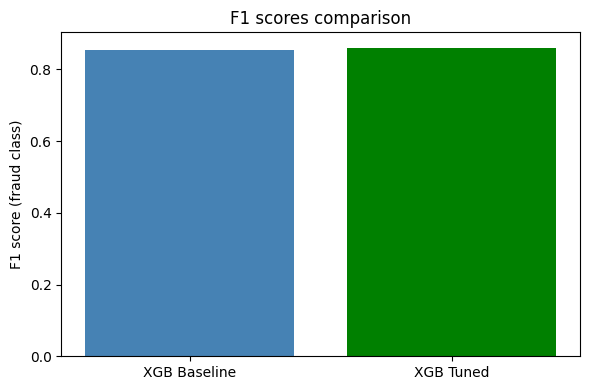

In [12]:
plt.figure(figsize=(6, 4))
plt.bar(results_df["model"], results_df["f1"], color=["steelblue", "green"])
plt.ylabel("F1 score (fraud class)")
plt.title("F1 scores comparison")
plt.tight_layout()
plt.show()

## 4. Feature importance

XGBoost also provides feature importances, lets see which features matter most.

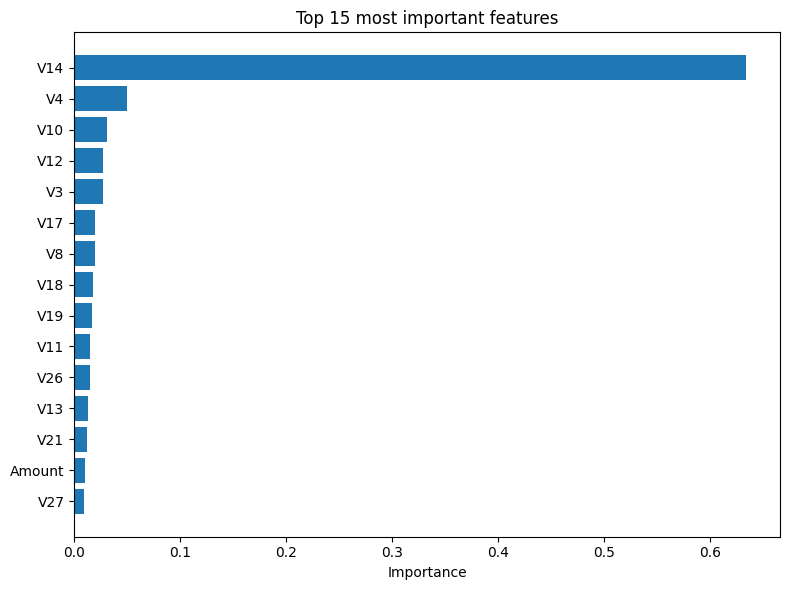

Top 10 features:
feature  importance
    V14    0.634665
     V4    0.049408
    V10    0.030549
    V12    0.027314
     V3    0.027120
    V17    0.019387
     V8    0.019230
    V18    0.017759
    V19    0.016548
    V11    0.015237


In [13]:
xgb_model = best_xgb.named_steps["model"]
importances = xgb_model.feature_importances_

feature_names = numeric_to_scale + other_features

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importance_df["feature"][:15][::-1], importance_df["importance"][:15][::-1])
plt.xlabel("Importance")
plt.title("Top 15 most important features")
plt.tight_layout()
plt.show()

print("Top 10 features:")
print(importance_df.head(10).to_string(index=False))

V14 dominates the feature importance with 63%, while other features contribute much less. Since these are PCA transformed features used to protect privacy, this confirms that the transformation successfully preserved the key fraud patterns while hiding the real customer data.

## 5. Conclusion

We got really good results with XGBoost on our fraud detection problem. Both models perform well, but the tuned version is slightly better with an F1 score of 0.86 compared to 0.85 for the baseline. 

Both beat our Random Forest model that got 0.83. Looking at what the models actually do: the baseline caught 73 out of 95 frauds while the tuned version caught 74. So the tuned model has a bit better recall at 77.9% versus 76.8%. Both models only made 3 false alarms, which is great. This means that when we tell someone their transaction is fraud, we are right 96% of the time. 

This is super important because false alarms would annoy customers and create extra work for the fraud team. What is interesting is that the baseline model already works really well just by using scale_pos_weight to handle the imbalanced data. Hyperparameter tuning improved things a bit, we caught one more fraud and increased the F1 score slightly, but the difference is not huge. 

XGBoost gives us the best balance we have seen so far between catching frauds and avoiding false positives. 

The tuned version is a bit better than the baseline and our previous models. The way it builds trees sequentially, where each new tree learns from the mistakes of previous one, work really well for our dataset